<a href="https://colab.research.google.com/github/shreyus3003/Deep_Learning/blob/master/Home_work_2_Graded/HomeWork2_autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

class Tensor:

  def __init__(self, data, requires_grad=False):
      self.data = data
      if not isinstance(data, np.ndarray):
          self.data = np.array(data)
      self.requires_grad = requires_grad
      self._grad = None
      self._grad_fn = None

  @property
  def shape(self):
      return self.data.shape

  @property
  def grad_fn(self):
      if not self.requires_grad:
          raise Exception('This tensor is not backpropagated')
      return self._grad_fn

  @property
  def grad(self):
      return self._grad

  def backward(self, grad=None):
      if not self.grad_fn:
          return False

      if grad is None and self._grad is None:
          grad = self.__class__(1., requires_grad=False)

      elif self.grad is not None:
          grad = self._grad

      if not self.requires_grad:
          raise Exception('This tensor is not backpropagated')

      self.grad_fn.backward(grad)
      return True

  def __str__(self):
      return f'Tensor({str(self.data)})'

  def add_grad(self, grad):
      if self._grad is None:
          self._grad = grad
      else:
          self._grad += grad

  def __add__(self, o): 
      if self.data is not None:
          self.data += o.data  
          return self
      self.data = o.data 
      return self

class Op:

  def forward(self):
      raise NotImplemented

  def backward(self, grad):
      raise NotImplemented

  def __call__(self, *args):
      self.out = self.forward(*args)
      self.out._grad_fn = self
      return self.out


class AddOp(Op):


  def forward(self, x: Tensor, y: Tensor):
      self.x = x
      self.y = y
      requires_grad = x.requires_grad or y.requires_grad
      return Tensor(x.data + y.data, requires_grad=requires_grad)

  def backward(self, grad):
      if self.x.requires_grad:

          if self.x.shape != grad.shape:
              axis = np.argmax(np.abs(np.array(self.x.shape) - np.array(grad.shape)))
              self.x.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
          else:
              self.x.add_grad(grad)
          if self.x.grad_fn:
              self.x.backward()
      if self.y.requires_grad:
          if self.y.shape != grad.shape:
              axis = np.argmax(np.abs(np.array(self.y.shape) - np.array(grad.shape)))
              self.y.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
          else:
              self.y.add_grad(grad)
          if self.y.grad_fn:
              self.y.backward()


class MulOp(Op):


  def forward(self, x: Tensor, y: Tensor):
      self.x = x
      self.y = y
      requires_grad = x.requires_grad or y.requires_grad
      return Tensor(x.data * y.data, requires_grad=requires_grad)

  def backward(self, grad):
      if self.x.requires_grad:
          self.x.add_grad(Tensor(grad.data * self.y.data, False))
          if self.x.grad_fn:
              self.x.backward()
      if self.y.requires_grad:
          self.y.add_grad(Tensor(grad.data * self.x.data, False))
          if self.y.grad_fn:
              self.y.backward()


In [0]:
class Layer:

  def forward(self):
      raise NotImplemented
  
  def backward(self, grad):
      raise NotImplemented

  def __call__(self, *args):
      return self.forward(*args)

class Sigmoid:

  def forward(self,x):
      self.x = x   
      return 1/(1+np.exp(-x))
    
  def backward(self, grad):
      grad_input = self.x*(1-self.x) * grad
      return grad_input

class Relu(Layer):

  def forward(self,x):
      self.x = x
      return np.maximum(np.zeros_like(x), x)
    
  def backward(self, grad):
      grad_input = (self.x > 0) * grad
      return grad_input

class SoftmaxCrossentropyWithLogits(Layer):

  def forward(self, x, y):
      self.x = x
      self.y = y

      exps = np.exp(x) 
      self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

      logits = self.softmax[np.arange(x.shape[0]),y]
      log_likelihood = -np.log(logits)
      loss = np.sum(log_likelihood) / x.shape[0]
      return loss
    
  def backward(self, grad=None):
      batch = self.x.shape[0]
      grad = self.softmax
      grad[np.arange(batch),self.y] -= 1
      grad = grad/batch
      return grad

class MSE(Layer):

  def forward(self, x, y):
      self.x = x
      self.y = y
      return ((x - y)**2) / (self.x.shape[0]*2)

  def backward(self, grad=None):
      return (self.x - self.y) / self.x.shape[0]


In [0]:
class Linear(Layer):

  def __init__(self, input, output, lr=0.0001):
    super().__init__()
    self.weight = 2*np.random.random((input, output)) - 1
    self.bias = 2*np.random.random((output)) - 1
    self.lr = lr

  def forward(self, x):
    self.x = x
    return np.dot(x,self.weight) + self.bias


  def backward(self, grad):
    bias_grad = grad.mean(axis=0)*self.x.shape[0]
    weight_grad = np.dot(self.x.T, grad)
    grad_input = np.dot(grad, self.weight.T)
    
    self.weight -= weight_grad * self.lr
    self.bias -= bias_grad * self.lr

    return grad_input

In [0]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


class Model(Layer):

  def __init__(self, lr=0.00001):
      self.lr = lr
      self.layers = [
          Linear(784,100, lr=self.lr),
          Relu(),
          Linear(100,200, lr=self.lr),
          Relu(),
          Linear(200,10, lr=self.lr)        
      ]

  def forward(self,x):
      for l in self.layers:
          x = l(x)
      return x

  def backward(self, grad):
      for l in self.layers[::-1]:
          grad = l.backward(grad)

      return grad




In [68]:
simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
ds = MNIST('./mnist', download=True, transform=simple)
ld = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 

mm = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0 


for epochs in range(10):
    cnt = 0
    total = 0
    for i, (img, label) in enumerate(ld):
        x = img.view(2,-1).numpy()

        res = mm(x)
        _loss = loss(res, label.numpy())
        total += label.data.size(0)
        #print(total)
        #cnt += (res == label.numpy()).sum()
        cnt += int(np.argmax(res) == np.argmax(label.numpy()))
        _loss_avg += _loss.mean() # running loss mean
        grad = loss.backward(1)
        mm.backward(grad)

        if i % 1000 == 0:
          print('Train - Epoch %d, Batch: %d, Loss: %f' % (epochs, i, _loss_avg/1000))
          _loss_avg = 0
        loss.backward()
        # optimizer.step()
        mm.backward(grad)
        #avg_loss /= len(data_test)
    print(' Accuracy: %f' % (float(cnt) / len(ds)))


Train - Epoch 0, Batch: 0, Loss: 0.297444
Train - Epoch 0, Batch: 1000, Loss: 127.260155
Train - Epoch 0, Batch: 2000, Loss: 74.195702
Train - Epoch 0, Batch: 3000, Loss: 54.780910
Train - Epoch 0, Batch: 4000, Loss: 43.540521
Train - Epoch 0, Batch: 5000, Loss: 39.814474
Train - Epoch 0, Batch: 6000, Loss: 33.861705
Train - Epoch 0, Batch: 7000, Loss: 32.655650
Train - Epoch 0, Batch: 8000, Loss: 32.593637
Train - Epoch 0, Batch: 9000, Loss: 28.926801
Train - Epoch 0, Batch: 10000, Loss: 23.248521
Train - Epoch 0, Batch: 11000, Loss: 23.116945
Train - Epoch 0, Batch: 12000, Loss: 23.351633
Train - Epoch 0, Batch: 13000, Loss: 21.474357
Train - Epoch 0, Batch: 14000, Loss: 20.736564
Train - Epoch 0, Batch: 15000, Loss: 19.564460
Train - Epoch 0, Batch: 16000, Loss: 21.144170
Train - Epoch 0, Batch: 17000, Loss: 19.467009
Train - Epoch 0, Batch: 18000, Loss: 17.570765
Train - Epoch 0, Batch: 19000, Loss: 18.207660
Train - Epoch 0, Batch: 20000, Loss: 17.332767
Train - Epoch 0, Batch: 21

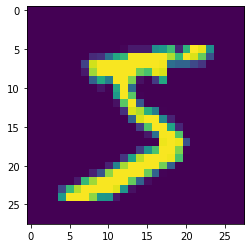

target: 5 predicted: 3


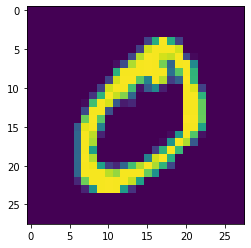

target: 0 predicted: 0


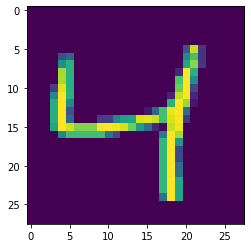

target: 4 predicted: 5


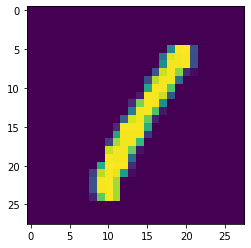

target: 1 predicted: 1


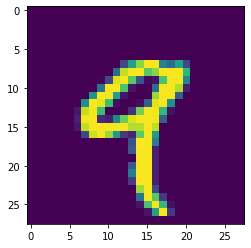

target: 9 predicted: 9


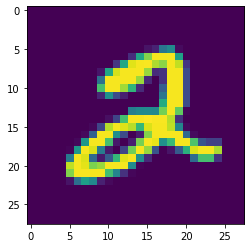

target: 2 predicted: 2


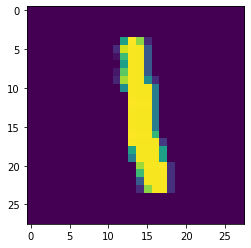

target: 1 predicted: 1


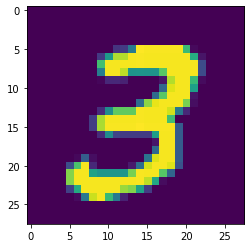

target: 3 predicted: 3


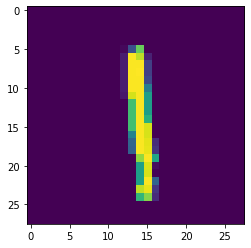

target: 1 predicted: 1


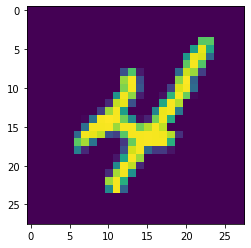

target: 4 predicted: 4


In [69]:
for i in range(10):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    res = mm(x)[0]
    pred = np.argmax(res)
    print(f'target: {target} predicted: {pred}' )